In [ ]:

#I-Data preprocessing

from keras.datasets import mnist
from keras.layers import Dense, Flatten
from keras.layers import Conv2D
import keras
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train=x_train.reshape(x_train.shape[0],28,28,1)
x_test=x_test.reshape(x_test.shape[0],28,28,1)
input_shape=(28,28,1)

#normalisation
x_train=x_train.astype('float32')
x_test=x_test.astype('float32')
print(type(x_train))
x_train/=255
x_test/=255


#convet class vectors to binary class matrices: 3 becomes [0,0,0,1,0,0,0,0,0,0]
y_train=keras.utils.to_categorical(y_train,10)
y_test=keras.utils.to_categorical(y_test,10)



11493376/11490434 [==============================] - 0s 0us/step
<class 'numpy.ndarray'>


In [ ]:
# II-Our model

from tensorflow.keras import Sequential
from keras.layers.convolutional import Convolution2D

classes=[0,1,2,3,4,5,6,7,8,9]
nbr_classes=len(classes)

def model_cnn():
  model = Sequential()
  model.add(Convolution2D(64,3,1,padding='valid'))
  model.add(Flatten())
  model.add(Dense(32,activation='relu'))
  model.add(Dense(nbr_classes,activation='softmax'))
  return model



In [ ]:
#III-Model Instanciation
my_model=model_cnn()
my_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

from tensorflow.keras import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers import Dense, Flatten
from keras.layers import Conv2D


In [ ]:
#IV Fonctions nécessaires pour l'attaque 


from math import tanh
import numpy as np
from numpy import array
from scipy import optimize
import torch
#Box constraints in 3 methods : 1- projected gradient descent(clipps the coordinates to be inside the box)
                               #2- the xi are not clipped , but instead we clipp the gradient: we replace f(x+delta) by f(min(max(x+delta,0),1))
                               #3-but the best is the one below with the variable_change tanh

import tensorflow as tf

if torch.cuda.is_available():
    device = torch.device("cuda")          
    # a CUDA device object


import numpy as np

k=0.09


def norm_p(delta, p):
  delta_1=delta
  from scipy.spatial import distance
  result=distance.minkowski(delta.flatten(),p)
  delta=delta_1
  return result


def func_map(x,y):
  return 0.5*(tanh(y)+1)-x

def variable_change(w,x):#ensures that x+delta belongs to [0,1]
  w=np.array(w).flatten()
  x=np.array(x).flatten()
  my_list=[]
  for w_i,x_i in zip(w,x):
    my_list.append(func_map(w_i,x_i))

  return np.array(my_list)  

  #since -1<=tanh(w)<=1, it follows 0<=x_i+delta_i<=1, so this solution will automatically be valid, we can think of this method as,a clipped descent gradient that eliminates 
  #problem of getting stuck in extreme regions



def objectif_function(my_array,t):  #this is f
  my_array=np.array([[my_array]])
  my_array=my_array.reshape(1,28,28,1)
  nn_output=my_model(my_array).numpy()
  index_max=np.argmax(nn_output)
  result=max(nn_output[0][index_max]-nn_output[0][t],0)

  return result

  
#what we're trying to do is to minimize D(x,x+delta)
  #such that f(x+delta)<=0 and x+delta belongs to [0,1]

def function_to_minimize(delta,p,x,c,t):
  my_norm=norm_p(delta,p)
  second_member=c*objectif_function(x+delta,t)
  return my_norm+second_member


def attack_l2(x,w,c,t):
    return function_to_minimize(variable_change(w,x),2,x,c,t)


def attack(x,net,n_attack,labels,device,w):


  
  result = optimize.minimize(attack_l2,x0=x,args=(w,1.8,7),method='SLSQP',
                           options={'maxiter':70})
  
  return result.x #contains the optimal solution


    





In [ ]:
new_set_after_attack=[]
#V Entraineemnt avec l'attaque
def train_with_attack(nbr,net,device):
  iteration=0

  #Train the network with PGD on attacked samples
  inputs=0#init
  for (data,label) in zip(x_train[0:2000],y_train[0:2000]): 
        w=np.zeros(data.shape)#initialization
        print('data_shape=',data.shape)
        inputs_after_attack = attack(data,my_model,1,y_train,device,[w]) 
        inputs_after_attack=inputs_after_attack.reshape((28, 28,1))
        new_set_after_attack.append(inputs_after_attack)
        iteration=iteration+1
        print("iteration number:",iteration)
  
  print('Finished Training')





In [ ]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

new_set_after_attack
train_with_attack(1,my_model,device)



data_shape= (28, 28, 1)

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

iteration number: 1
data_shape= (28, 28, 1)
iteration number: 2
data_shape= (28, 28, 1)
iteration number: 3
data_shape= (28, 28, 1)
iteration number: 4
data_shape= (28, 28, 1)
iteration number: 5
data_shape= (28, 28, 1)
iteration number: 6
data_shape= (28, 28, 1)
iteration number: 7
data_shape= (28, 28, 1)
iteration number: 8
data_shape= (28, 28, 1)
iteration number: 9
data_shape= (28, 28, 1)
iteration number: 10
data_shape= (28, 28, 1)
iteration number: 11
data_shape= (28, 28, 1

In [ ]:
import numpy as np
new_set_after_attack=np.array(new_set_after_attack)
my_model.fit(new_set_after_attack, y_train, validation_data=(x_test, y_test), epochs=200)

In [ ]:

score = my_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
from sklearn.metrics import classification_report
import numpy as np
Y_test = np.argmax(y_test, axis=-1) # Convert one-hot to index
y_pred = my_model.predict_classes(x_test)
print(classification_report(Y_test, y_pred))

Test loss: 45.013710021972656
Test accuracy: 0.10279999673366547
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       980
           1       0.00      0.00      0.00      1135
           2       0.00      0.00      0.00      1032
           3       0.00      0.00      0.00      1010
           4       0.00      0.00      0.00       982
           5       0.00      0.00      0.00       892
           6       0.00      0.00      0.00       958
           7       0.10      1.00      0.19      1028
           8       0.00      0.00      0.00       974
           9       0.00      0.00      0.00      1009

    accuracy                           0.10     10000
   macro avg       0.01      0.10      0.02     10000
weighted avg       0.01      0.10      0.02     10000



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
 import collections, numpy
print(y_pred)
collections.Counter(y_pred)


[7 7 7 ... 7 7 7]


Counter({7: 10000})

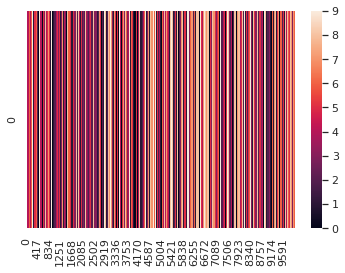

In [ ]:
import collections
print(y_pred[0:500])
collections.Counter(y_pred)

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 7 7 7 7 7 7 7 

Counter({7: 10000})